### Import libraries

In [2]:
import pandas as pd
import csv 
from bs4 import BeautifulSoup
import requests

In [9]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
resp = requests.get(url)
toronto_html = BeautifulSoup(resp.content)

### The dataframe will consist of three columns: PostalCode, Borough, and Neighborhood

In [14]:
soup = BeautifulSoup(str(toronto_html))
neighborhood_table = soup.find('table')
tbl_str = str(neighborhood_table.extract())
toronto_df = pd.read_html(tbl_str)[0]
toronto_df.head()

,Postal code,Borough,Neighborhood
0,M1A,Not assigned,NaN
1,M2A,Not assigned,NaN
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Regent Park / Harbourfront


In [21]:
toronto_df.shape

(103, 3)

### Processing the cells that have an assigned borough. Ignoring cells with a borough that is Not assigned

#### If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough.

In [17]:
borough_na = toronto_df[toronto_df.Borough == 'Not assigned']
toronto_df.drop(borough_na.index, inplace=True)

In [18]:
toronto_df.head()

,Postal code,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Regent Park / Harbourfront
5,M6A,North York,Lawrence Manor / Lawrence Heights
6,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government


In [19]:
toronto_df.shape

(103, 3)

### Harbourfront and Regent Park. These two rows will be combined into one row with the neighborhoods separated with a comma as shown in row 11 in the above table.

#### We are using the group by function

In [24]:
toronto_df.columns = ['PostalCode'] + list(toronto_df.columns)[1:]

In [26]:
toronto_df = toronto_df.groupby(['PostalCode', 'Borough'])['Neighborhood'].apply(lambda x: ', '.join(x)).to_frame() 
toronto_df.reset_index(inplace=True)
toronto_df.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,Malvern / Rouge
1,M1C,Scarborough,Rouge Hill / Port Union / Highland Creek
2,M1E,Scarborough,Guildwood / Morningside / West Hill
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


### Adding Langtitute and Longtitude, Using Geocoder Python package 

In [32]:
geo_url = "https://cocl.us/Geospatial_data"

geocode_df = pd.read_csv(geo_url)
geocode_df.rename(columns={'Postal Code': 'PostalCode'}, inplace=True)
toronto_df = pd.merge(toronto_df, geocode_df, on='PostalCode')
toronto_df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,Malvern / Rouge,43.806686,-79.194353
1,M1C,Scarborough,Rouge Hill / Port Union / Highland Creek,43.784535,-79.160497
2,M1E,Scarborough,Guildwood / Morningside / West Hill,43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


### Import additional libraries

In [67]:
import numpy as np 
import json
import requests 
from pandas.io.json import json_normalize

In [69]:
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.1.1f             |       h516909a_0         2.1 MB  conda-forge
    branca-0.4.0               |             py_0          26 KB  conda-forge
    certifi-2020.4.5.1         |   py36h9f0ad1d_0         151 KB  conda-forge
    ca-certificates-2020.4.5.1 |       hecc5488_0         146 KB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    ------------------------------------------------------------
                       

### Forsquare 

In [72]:
CLIENT_ID = 'MCGCXOF1JPF1PJDQWHUZDHXZMFPNAEETWDAF2J3FMCWL5EKM' 
CLIENT_SECRET = 'KHXOF5SQNMNIB3ZVONJABIPOKZ2ZNW1CW3SC0JZ3JPPDNRHT'
VERSION = '20200126' 
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
LIMIT = 100
radius = 500

Your credentails:
CLIENT_ID: MCGCXOF1JPF1PJDQWHUZDHXZMFPNAEETWDAF2J3FMCWL5EKM
CLIENT_SECRET:KHXOF5SQNMNIB3ZVONJABIPOKZ2ZNW1CW3SC0JZ3JPPDNRHT


In [75]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Exploring all the venues around Toronto Neighbourhood

In [85]:
toronto_venues = getNearbyVenues(names=toronto_df['Neighborhood'],
                                   latitudes=toronto_df['Latitude'],
                                   longitudes=toronto_df['Longitude'])

Malvern / Rouge
Rouge Hill / Port Union / Highland Creek
Guildwood / Morningside / West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park / Ionview / East Birchmount Park
Golden Mile / Clairlea / Oakridge
Cliffside / Cliffcrest / Scarborough Village West
Birch Cliff / Cliffside West
Dorset Park / Wexford Heights / Scarborough Town Centre
Wexford / Maryvale
Agincourt
Clarks Corners / Tam O'Shanter / Sullivan
Milliken / Agincourt North / Steeles East / L'Amoreaux East
Steeles West / L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview / Henry Farm / Oriole
Bayview Village
York Mills / Silver Hills
Willowdale / Newtonbrook
Willowdale
York Mills West
Willowdale
Parkwoods
Don Mills
Don Mills
Bathurst Manor / Wilson Heights / Downsview North
Northwood Park / York University
Downsview
Downsview
Downsview
Downsview
Victoria Village
Parkview Hill / Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The Danforth West / Riverdale
India Bazaar / The Beaches 

In [86]:
print(toronto_venues.shape)
toronto_venues.head()

(2146, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Malvern / Rouge,43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
1,Malvern / Rouge,43.806686,-79.194353,Interprovincial Group,43.805630,-79.200378,Print Shop
2,Malvern / Rouge,43.806686,-79.194353,T Hamilton & Son Roofing Inc,43.807985,-79.198194,Construction & Landscaping
3,Rouge Hill / Port Union / Highland Creek,43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
4,Guildwood / Morningside / West Hill,43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store


In [91]:
print('There are {} Neighborhoods around Toronto.'.format(len(toronto_venues['Venue Category'].unique())))

There are 262 Neighborhoods around Toronto.


### One hot encoding

In [95]:
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]
toronto_onehot.head()

,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [97]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()

### Clusters

In [102]:
kclusters = 3

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)
kmeans.labels_[0:100]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
       1, 1, 1, 1, 1, 1, 0], dtype=int32)

In [107]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Common Venue,2nd Common Venue,3rd Common Venue,4th Common Venue,5th Common Venue,6th Common Venue,7th Common Venue,8th Common Venue,9th Common Venue,10th Common Venue
0,Agincourt,Latin American Restaurant,Skating Rink,Lounge,Breakfast Spot,Clothing Store,Doner Restaurant,Diner,Discount Store,Distribution Center,Dog Run
1,Alderwood / Long Branch,Pizza Place,Gym,Coffee Shop,Pharmacy,Skating Rink,Athletics & Sports,Pub,Pool,Sandwich Place,Diner
2,Bathurst Manor / Wilson Heights / Downsview North,Bank,Coffee Shop,Shopping Mall,Ice Cream Shop,Sushi Restaurant,Deli / Bodega,Middle Eastern Restaurant,Restaurant,Chinese Restaurant,Fried Chicken Joint
3,Bayview Village,Café,Chinese Restaurant,Bank,Japanese Restaurant,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop,Dessert Shop,Doner Restaurant
4,Bedford Park / Lawrence Manor East,Coffee Shop,Restaurant,Sandwich Place,Italian Restaurant,Sushi Restaurant,Comfort Food Restaurant,Pharmacy,Pizza Place,Pub,Café


In [108]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [110]:
toronto_merged = toronto_df
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
toronto_merged.head() 

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Common Venue,2nd Common Venue,3rd Common Venue,4th Common Venue,5th Common Venue,6th Common Venue,7th Common Venue,8th Common Venue,9th Common Venue,10th Common Venue
0,M1B,Scarborough,Malvern / Rouge,43.806686,-79.194353,1.0,Print Shop,Fast Food Restaurant,Construction & Landscaping,Women's Store,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop
1,M1C,Scarborough,Rouge Hill / Port Union / Highland Creek,43.784535,-79.160497,1.0,Bar,Women's Store,Dessert Shop,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop
2,M1E,Scarborough,Guildwood / Morningside / West Hill,43.763573,-79.188711,1.0,Electronics Store,Intersection,Mexican Restaurant,Bank,Medical Center,Breakfast Spot,Rental Car Location,Drugstore,Donut Shop,Doner Restaurant
3,M1G,Scarborough,Woburn,43.770992,-79.216917,1.0,Coffee Shop,Korean Restaurant,Women's Store,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Drugstore
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,1.0,Caribbean Restaurant,Gas Station,Bakery,Bank,Athletics & Sports,Thai Restaurant,Fried Chicken Joint,Hakka Restaurant,Donut Shop,Doner Restaurant


In [113]:
from sklearn.cluster import KMeans  
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=15, random_state=8)  
X = toronto_onehot.drop(['Neighborhood'], axis=1)
X.head()

,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Generating a map to visualize the neighborhoods and how they cluster together. 

In [114]:
kmeans.fit(X)
kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [115]:
def get_inertia(n_clusters):
    km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=15, random_state=8)
    km.fit(X)
    return km.inertia_

Text(0, 0.5, 'Error')

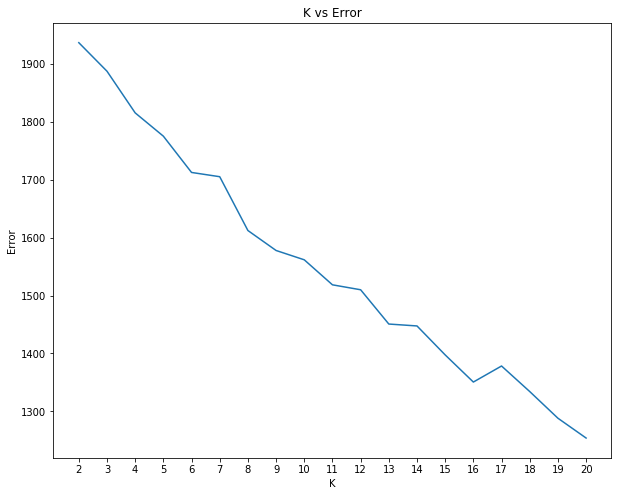

In [118]:
import matplotlib.pyplot as plt
import seaborn as sns
scores = [get_inertia(x) for x in range(2, 21)]
plt.figure(figsize=[10, 8])
sns.lineplot(x=range(2, 21), y=scores)
plt.title("K vs Error")
plt.xticks(range(2, 21))
plt.xlabel("K")
plt.ylabel("Error")

From the above vizual, we can see that the error reduces starting from K=6